In [28]:
import pandas as pd
import numpy as np
# import scipy as sp
# from datetime import datetime
from dateutil import parser
from matplotlib import pyplot as plt
from functools import reduce
from IPython.display import display, HTML
from scipy.stats import expon
import itertools

### Clusters of interest  
E-128 nodes, IDs: 9,10,11  
F-256 nodes, IDs: 14,15,16,17

In [2]:
E_IDs = [9, 10, 11]
F_IDs = [14,15,16,17]

In [51]:
# Read LANL data
lanl = pd.read_csv("data/LANL.csv")
lanl.head()

,System,machine type,nodes,procstot,procsinnode,nodenum,nodenumz,node install,node prod,node decom,...,Prob Started (mm/dd/yy hh:mm),Prob Fixed (mm/dd/yy hh:mm),Down Time,Facilities,Hardware,Human Error,Network,Undetermined,Software,Same Event
0,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,6/21/2005 10:54,6/21/2005 11:00,6,NaN,Graphics Accel Hdwr,NaN,NaN,NaN,NaN,No
1,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 9:13,9/6/2005 9:19,6,NaN,NaN,NaN,NaN,NaN,Other Software,No
2,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 10:32,9/6/2005 10:46,14,NaN,NaN,NaN,NaN,Undetermined,NaN,No
3,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 14:50,9/6/2005 15:08,18,NaN,NaN,NaN,NaN,NaN,Other Software,No
4,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/8/2005 16:52,9/8/2005 16:57,5,NaN,NaN,NaN,NaN,Undetermined,NaN,No


In [12]:
lanl.describe()

,System,nodes,procstot,procsinnode,nodenum,nodenumz,mem,cputype,memtype,num intercon,Down Time
count,23739.000000,23613.000000,23613.000000,23613.000000,23613.000000,23613.000000,23613.00000,23613.000000,23613.000000,23613.000000,23739.000000
mean,12.316020,412.039809,3637.940118,58.041672,328.775590,186.204506,27.35599,2.036929,2.036929,5.117732,352.381440
std,7.728558,434.469638,2069.976059,61.866268,534.668188,274.941531,54.55763,1.721330,1.721330,4.591858,4683.012911
min,2.000000,1.000000,4.000000,2.000000,0.000000,0.000000,1.00000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,49.000000,2048.000000,4.000000,9.000000,8.000000,8.00000,1.000000,1.000000,2.000000,25.000000
50%,16.000000,128.000000,4096.000000,4.000000,40.000000,37.000000,16.00000,2.000000,2.000000,2.000000,59.000000
75%,19.000000,1024.000000,6152.000000,128.000000,384.000000,241.000000,32.00000,2.000000,2.000000,12.000000,144.000000
max,24.000000,1024.000000,6152.000000,256.000000,2047.000000,1023.000000,1024.00000,8.000000,8.000000,12.000000,319482.000000


In [159]:
def change_timestamp(col):
    col = parser.parse(col)

lanl_filter = lanl.copy()
lanl_filter['tm_hour'] = lanl_filter["Prob Started (mm/dd/yy hh:mm)"].apply(lambda d: parser.parse(d).timetuple().tm_hour)
lanl_filter[(lanl_filter['tm_hour'] > 8) & (lanl_filter['tm_hour'] < 18)]


,System,machine type,nodes,procstot,procsinnode,nodenum,nodenumz,node install,node prod,node decom,...,Prob Fixed (mm/dd/yy hh:mm),Down Time,Facilities,Hardware,Human Error,Network,Undetermined,Software,Same Event,tm_hour
0,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,6/21/2005 11:00,6,NaN,Graphics Accel Hdwr,NaN,NaN,NaN,NaN,No,10
1,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 9:19,6,NaN,NaN,NaN,NaN,NaN,Other Software,No,9
2,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 10:46,14,NaN,NaN,NaN,NaN,Undetermined,NaN,No,10
3,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/6/2005 15:08,18,NaN,NaN,NaN,NaN,NaN,Other Software,No,14
4,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/8/2005 16:57,5,NaN,NaN,NaN,NaN,Undetermined,NaN,No,16
5,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/9/2005 9:51,7,NaN,NaN,NaN,NaN,Undetermined,NaN,No,9
6,2,cluster,49.0,6152.0,80.0,0.0,0.0,5-Apr,5-Jun,current,...,9/9/2005 11:55,11,NaN,NaN,NaN,NaN,NaN,Other Software,No,11
7,2,cluster,49.0,6152.0,128.0,1.0,1.0,Nov-96,Jan-97,5-Nov,...,2/23/1997 14:00,60,NaN,NaN,NaN,NaN,NaN,DST,No,13
9,2,cluster,49.0,6152.0,128.0,1.0,1.0,Nov-96,Jan-97,5-Nov,...,3/3/1997 10:25,25,NaN,Maintenance,NaN,NaN,NaN,NaN,No,10
10,2,cluster,49.0,6152.0,128.0,1.0,1.0,Nov-96,Jan-97,5-Nov,...,3/5/1997 17:40,10,NaN,NaN,NaN,NaN,NaN,DST,No,17


In [4]:
# Drop useless columns
for col in lanl:
    if len(lanl[col].unique()) == 1:
        print("Dropping: ", str(col))
        del lanl[col]
        

Dropping:  Same Event


In [5]:
# look at the different possibilities in each column
for col in lanl:
    print(col, ": ", lanl[col].unique())

System :  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
machine type :  ['cluster' 'smp' 'numa' nan]
nodes :  [  4.90000000e+01   1.28000000e+02   3.20000000e+01   1.00000000e+00
   1.64000000e+02   2.56000000e+02   5.12000000e+02   1.60000000e+01
              nan   1.02400000e+03   5.00000000e+00]
procstot :  [  6.15200000e+03   5.12000000e+02   1.28000000e+02   8.00000000e+00
   3.28000000e+02   1.02400000e+03   2.56000000e+02   2.04800000e+03
              nan   4.09600000e+03   4.00000000e+00   5.44000000e+02
   3.20000000e+01]
procsinnode :  [  80.  128.    4.    8.    2.  256.   nan   32.]
nodenum :  [   0.    1.    2. ...,  436.  442.  447.]
nodenumz :  [  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   9.94000000e+02
   1.00000000e+03   1.02000000e+03]
node install :  ['5-Apr' 'Nov-96' '3-Aug' 'before tracking' '1-Mar' '2-Dec' '5-Mar' '4-Nov'
 'Oct-96' nan '2-Mar' '2-Aug' '1-Oct' '1-Aug' 'Jan-98' 'Oct-98' '2-Nov']
node prod :  ['5-Jun' 'Jan-97'

In [15]:
# cluster E with 128 nodes
E = lanl.loc[lanl["System"] == 9]
E_temp = lanl.loc[lanl["System"] == 10]
E.append(E_temp)
E_temp = lanl.loc[lanl["System"] == 11]
E.append(E_temp)
E.describe()

,System,nodes,procstot,procsinnode,nodenum,nodenumz,mem,cputype,memtype,num intercon,Down Time
count,280.0,280.0,280.0,280.0,280.000000,280.000000,280.0,280.0,280.0,280.0,280.000000
mean,9.0,256.0,512.0,2.0,113.150000,113.150000,4.0,8.0,8.0,1.0,1039.157143
std,0.0,0.0,0.0,0.0,73.045714,73.045714,0.0,0.0,0.0,0.0,8922.923477
min,9.0,256.0,512.0,2.0,0.000000,0.000000,4.0,8.0,8.0,1.0,0.000000
25%,9.0,256.0,512.0,2.0,63.750000,63.750000,4.0,8.0,8.0,1.0,1.000000
50%,9.0,256.0,512.0,2.0,100.000000,100.000000,4.0,8.0,8.0,1.0,10.000000
75%,9.0,256.0,512.0,2.0,162.750000,162.750000,4.0,8.0,8.0,1.0,86.500000
max,9.0,256.0,512.0,2.0,255.000000,255.000000,4.0,8.0,8.0,1.0,139845.000000


In [16]:
# cluster F with 256 nodes
F = lanl.loc[lanl["System"] == 14]
F_temp = lanl.loc[lanl["System"] == 15]
F.append(F_temp)
F_temp = lanl.loc[lanl["System"] == 16]
F.append(F_temp)
F_temp = lanl.loc[lanl["System"] == 17]
F.append(F_temp)
# F.head()
F.describe()

,System,nodes,procstot,procsinnode,nodenum,nodenumz,mem,cputype,memtype,num intercon,Down Time
count,125.0,125.0,125.0,125.0,125.000000,125.000000,125.0,125.0,125.0,125.0,125.000000
mean,14.0,128.0,256.0,2.0,179.216000,179.216000,4.0,8.0,8.0,1.0,5911.256000
std,0.0,0.0,0.0,0.0,41.018797,41.018797,0.0,0.0,0.0,0.0,32485.105039
min,14.0,128.0,256.0,2.0,129.000000,129.000000,4.0,8.0,8.0,1.0,0.000000
25%,14.0,128.0,256.0,2.0,138.000000,138.000000,4.0,8.0,8.0,1.0,2.000000
50%,14.0,128.0,256.0,2.0,174.000000,174.000000,4.0,8.0,8.0,1.0,15.000000
75%,14.0,128.0,256.0,2.0,208.000000,208.000000,4.0,8.0,8.0,1.0,618.000000
max,14.0,128.0,256.0,2.0,255.000000,255.000000,4.0,8.0,8.0,1.0,255840.000000


In [17]:
# get data for smarter plots
date_sort = lanl.sort_values("Prob Started (mm/dd/yy hh:mm)")

first_issue = parser.parse(date_sort["Prob Started (mm/dd/yy hh:mm)"].min())
last_issue = parser.parse(date_sort["Prob Fixed (mm/dd/yy hh:mm)"].max())

print("First Time: ", first_issue)
print("Last Time: ", last_issue)
time_difference = last_issue - first_issue
interval_size = int(time_difference.total_seconds()/60)

print("Minutes: ", interval_size)

plt.close('all')

graph_data = {}
for ID in date_sort["System"].unique():
    graph_data[ID] = np.zeros(interval_size)

First Time:  1998-01-01 10:28:00
Last Time:  2005-09-09 09:51:00
Minutes:  4043483


In [18]:
# fig, ax = plt.subplots()
# ax.plot(r.date, r.adj_close)

# # format the ticks
# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# # round to nearest years...
# datemin = np.datetime64(r.date[0], 'Y')
# datemax = np.datetime64(r.date[-1], 'Y') + np.timedelta64(1, 'Y')
# ax.set_xlim(datemin, datemax)

In [20]:
# setup lists to graph by Minute
for index, row in date_sort.iterrows():
    issue_start_time = int((parser.parse(row["Prob Started (mm/dd/yy hh:mm)"]) - first_issue).total_seconds()/60)
    issue_end_time = int((parser.parse(row["Prob Fixed (mm/dd/yy hh:mm)"]) - first_issue).total_seconds()/60)
    issue_end_time = min(issue_end_time, interval_size)
    i = issue_start_time
    while i < issue_end_time:
        graph_data[row["System"]][i] += 1
        i += 1

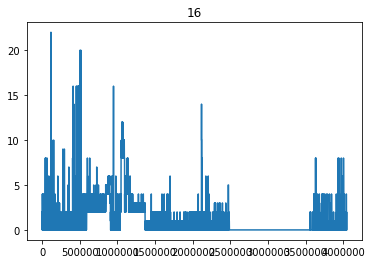

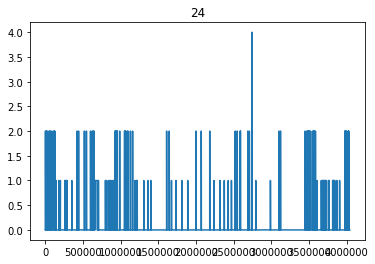

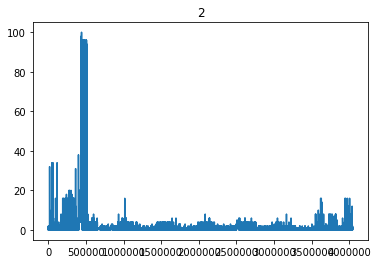

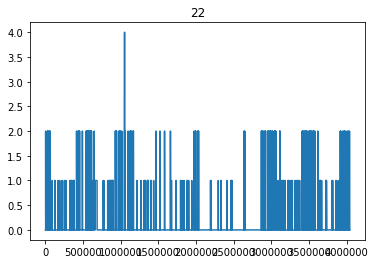

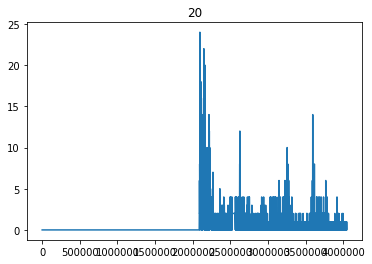

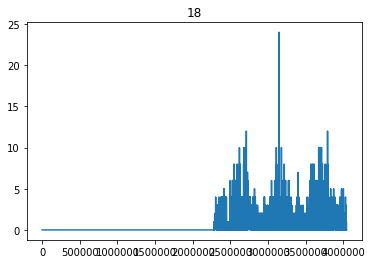

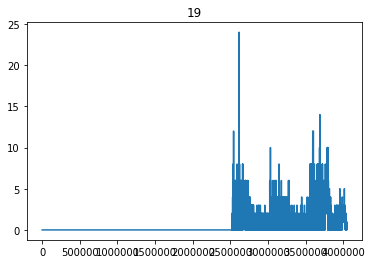

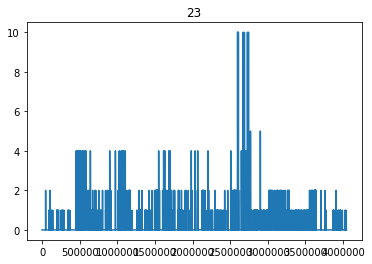

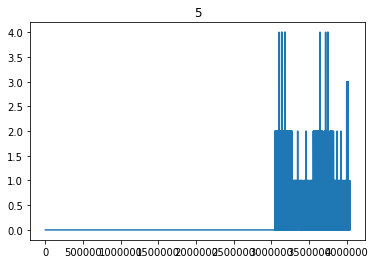

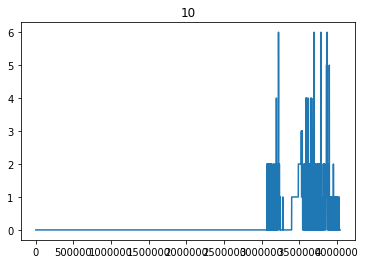

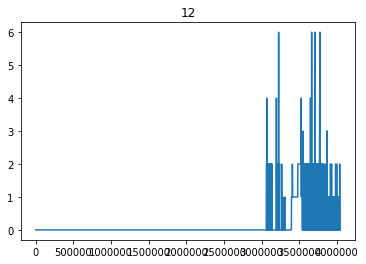

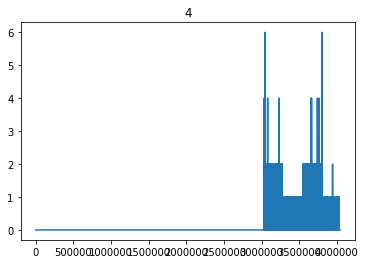

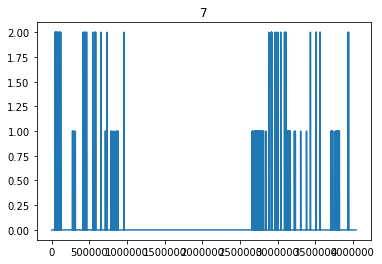

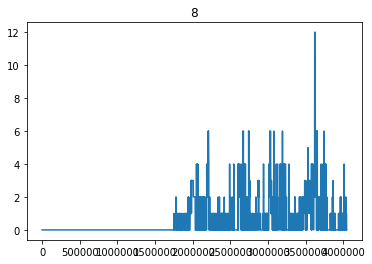

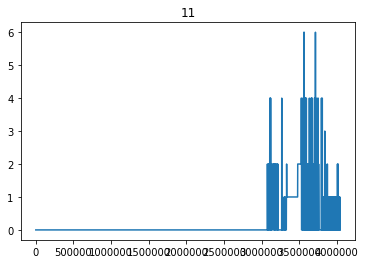

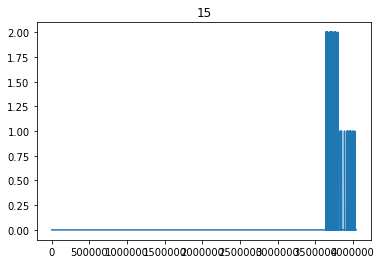

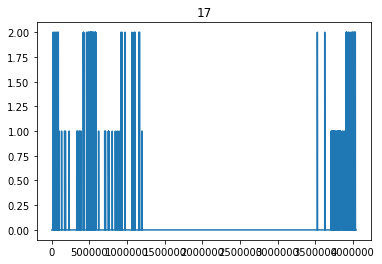

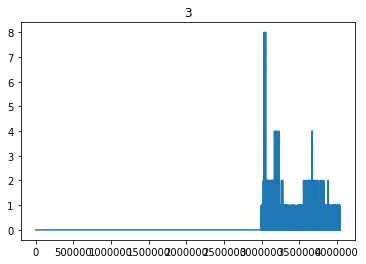

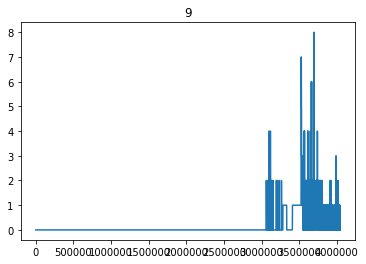

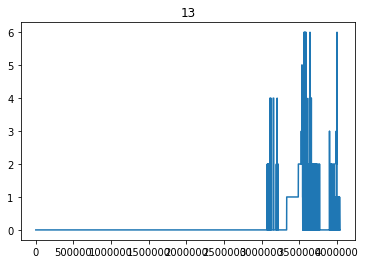

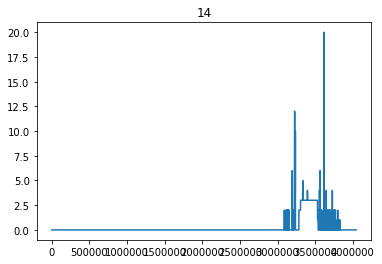

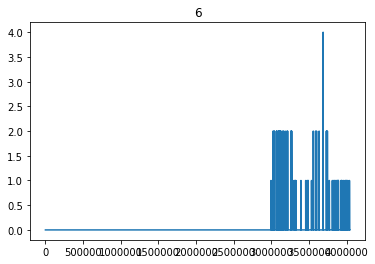

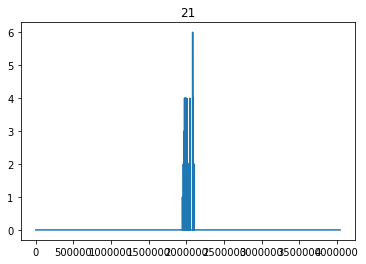

In [21]:
# graph the lists
for key in graph_data:
    fig, ax = plt.subplots()
    ax.plot(range(0,interval_size), graph_data[key])
    ax.set_title(key)
    plt.show()
# fig, ax = plt.subplots()
# ax.plot(range(0,interval_size), graph_data[9])
# plt.show()

Threshold:  469.8419197663479
Outliers:  1599  ~ 0.0673575129534 %


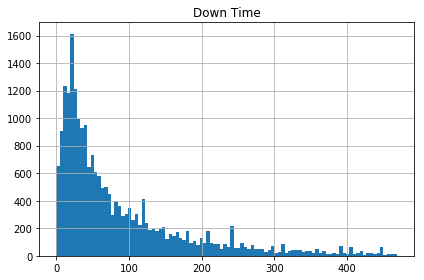

In [22]:
# Plot Down Times
plt.close('all')
# fig, ax = plt.subplots()

down_time_mean = date_sort["Down Time"].mean()
down_time_std = date_sort["Down Time"].std()
down_time_count = date_sort["Down Time"].count()
threshold = down_time_mean+down_time_mean/3#+(down_time_std*1/1000)
# threshold = 100
outliers = len(date_sort.loc[date_sort["Down Time"] > threshold])
print("Threshold: ", threshold)
print("Outliers: ", outliers, " ~", (outliers/down_time_count), "%")

down_time_clean = date_sort.loc[date_sort["Down Time"] <= threshold]
down_time_clean.hist(column="Down Time", bins=100)

plt.tight_layout()
plt.show()

Not all errors are labelled in the columns.
At most one cause is identified for each error.

In [12]:
print(lanl.shape)
qualities = ['Facilities', 'Hardware', 'Human Error', 'Network', 'Undetermined', 'Software']
clauses = list(map(lambda s: lanl[s].notnull(), qualities))
query = ~(reduce(lambda c1, c2: c1 | c2, clauses))
lanl_allnull = lanl.loc[query]
print(lanl_allnull.shape)
print(lanl_allnull.shape[0] / lanl.shape[0])
for qual in qualities:
    print(qual, lanl_allnull[qual].unique())
num_qual = len(qualities)
pairs = []
for i in range(num_qual):
    for j in range(i+1, num_qual):
        pairs.append(clauses[i] & clauses[j])
geq_two = reduce(lambda c1, c2: c1 | c2, pairs)
lanl_geqtwo = lanl.loc[geq_two]
print(lanl_geqtwo.shape)
neq_nodenum = lanl.loc[lanl['nodenum'] != lanl['nodenumz']]
neq_nodenum

(23739, 25)
(453, 25)
0.019082522431441932
Facilities [nan]
Hardware [nan]
Human Error [nan]
Network [nan]
Undetermined [nan]
Software [nan]
(0, 25)


,System,machine type,nodes,procstot,procsinnode,nodenum,nodenumz,node install,node prod,node decom,...,purpose,Prob Started (mm/dd/yy hh:mm),Prob Fixed (mm/dd/yy hh:mm),Down Time,Facilities,Hardware,Human Error,Network,Undetermined,Software
8200,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,5/1/2001 11:30,5/1/2001 12:30,60,UPS,NaN,NaN,NaN,NaN,NaN
8201,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,6/20/2001 9:00,6/20/2001 18:15,555,NaN,Maintenance,NaN,NaN,NaN,NaN
8202,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,6/26/2001 9:00,6/26/2001 17:45,525,NaN,Other,NaN,NaN,NaN,NaN
8203,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,7/10/2001 8:00,7/10/2001 9:36,96,NaN,NaN,Human Error,NaN,NaN,NaN
8204,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,8/15/2001 11:10,8/15/2001 11:12,2,NaN,NaN,NaN,NaN,NaN,Other Software
8205,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,8/19/2001 22:26,8/20/2001 14:30,964,NaN,Power Supply,NaN,NaN,NaN,NaN
8206,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,8/22/2001 17:00,8/22/2001 18:05,65,Power Outage,NaN,NaN,NaN,NaN,NaN
8207,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,10/9/2001 8:00,11/12/2001 21:15,49815,NaN,NaN,NaN,NaN,NaN,Resource Mgmt System
8208,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,11/27/2001 7:27,11/27/2001 9:00,93,Power Spike,NaN,NaN,NaN,NaN,NaN
8209,8,cluster,164.0,328.0,2.0,1.0,0.0,1-Mar,1-Apr,current,...,compute,12/6/2001 23:15,12/7/2001 9:15,600,NaN,NaN,NaN,Network,NaN,NaN


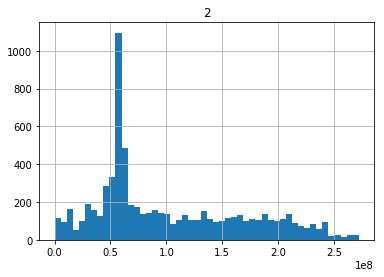

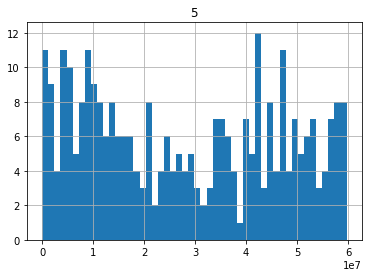

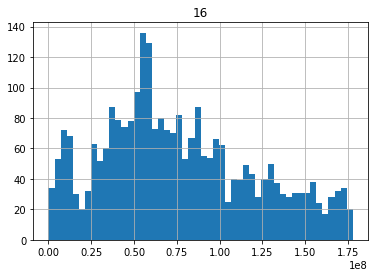

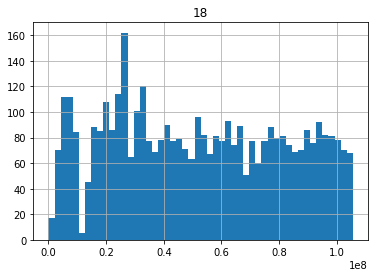

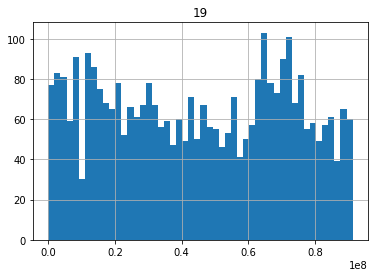

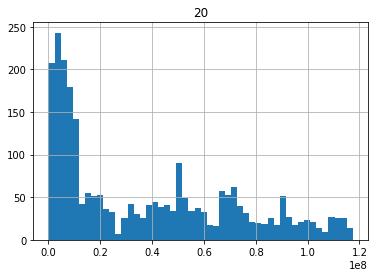

In [53]:
for sys_id in [2, 5, 16, 18, 19, 20]:
#sys_id = 2
    lanl_node24 = lanl.loc[lanl['System'] == sys_id]
    start_col = lanl_node24['Prob Started (mm/dd/yy hh:mm)']
    base_time = min([parser.parse(entry) for entry in start_col])

    def convert_to_seconds(s):
        timediff = parser.parse(s) - base_time
        return timediff.total_seconds()

    start_times = start_col.map(convert_to_seconds)

    plt.figure()
    start_times.hist(bins=50)
    plt.title(str(sys_id))
    plt.show()

Stratify failures in 2, 16, 18, 19, 20

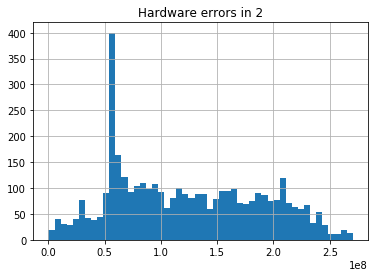

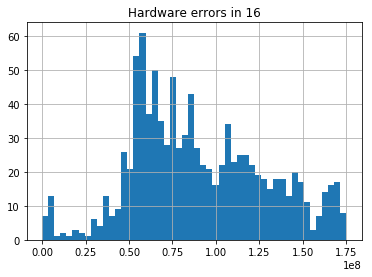

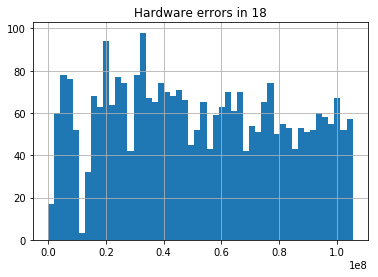

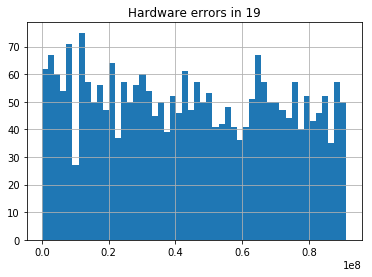

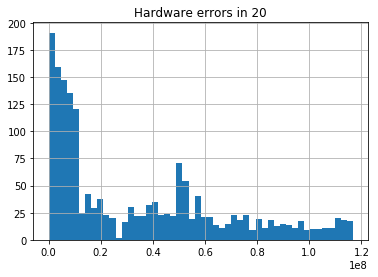

In [49]:
for sys_id in [2, 16, 18, 19, 20]:
    #for category in ['Facilities', 'Hardware', 'Human Error', 'Network', 'Undetermined', 'Software']:
    for category in ['Hardware',]:
        lanl_node = lanl.loc[(lanl['System'] == sys_id) & (lanl[category].notnull())]
        start_col = lanl_node['Prob Started (mm/dd/yy hh:mm)']
        base_time = min([parser.parse(entry) for entry in start_col])

        def convert_to_seconds(s):
            timediff = parser.parse(s) - base_time
            return timediff.total_seconds()

        start_times = start_col.map(convert_to_seconds)
        plt.figure()
        start_times.hist(bins=50)
        plt.title('{} errors in {}'.format(category, sys_id))
        plt.show()

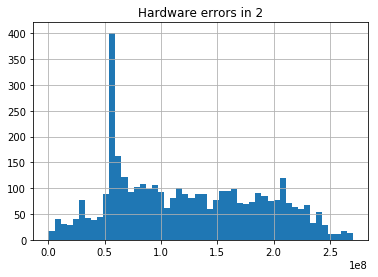

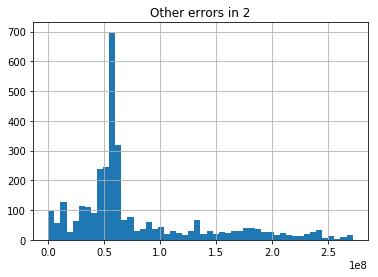

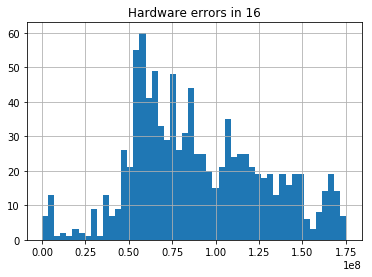

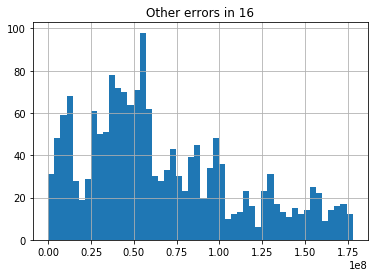

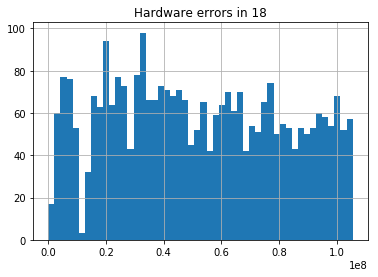

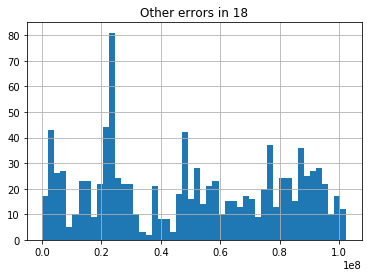

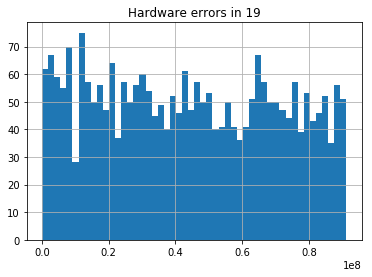

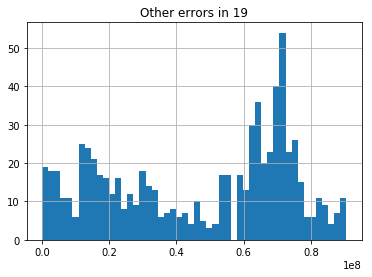

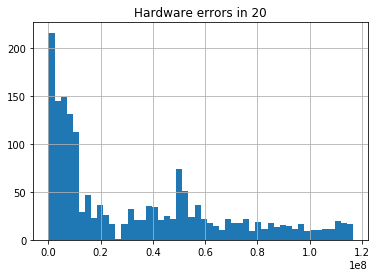

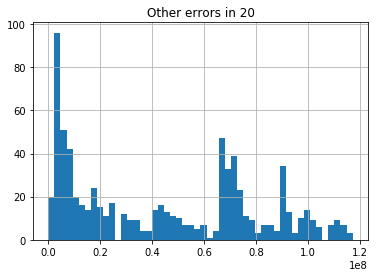

In [12]:
for sys_id in [2, 16, 18, 19, 20]:
    #for category in ['Facilities', 'Hardware', 'Human Error', 'Network', 'Undetermined', 'Software']:
    lanl_node = lanl.loc[lanl['System'] == sys_id]
    hardware_series = lanl_node.loc[lanl_node['Hardware'].notnull()]
    other_series = lanl_node.loc[lanl_node['Hardware'].isnull()]
    for fail_series, category in zip([hardware_series, other_series], ['Hardware', 'Other']):
        start_col = fail_series['Prob Fixed (mm/dd/yy hh:mm)']
        base_time = min([parser.parse(entry) for entry in start_col])

        def convert_to_seconds(s):
            timediff = parser.parse(s) - base_time
            return timediff.total_seconds()

        start_times = start_col.map(convert_to_seconds)
        plt.figure()
        start_times.hist(bins=50)
        plt.title('{} errors in {}'.format(category, sys_id))
        plt.show()

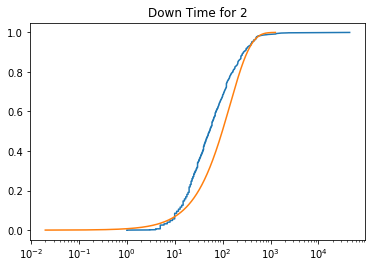

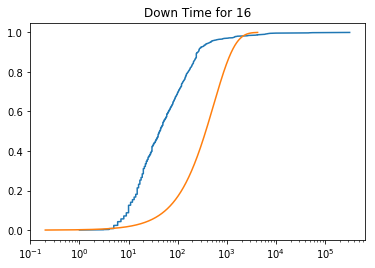

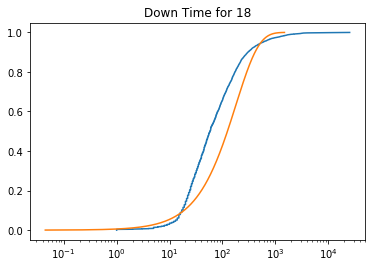

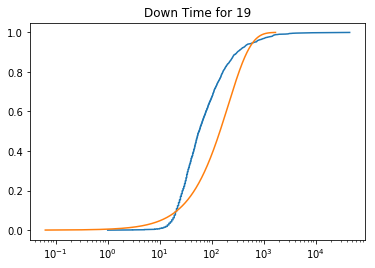

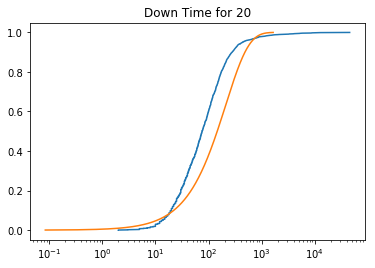

In [23]:
for sys_id in [2, 16, 18, 19, 20]:
    lanl_node = lanl.loc[lanl['System'] == sys_id]
    dt_series = lanl_node['Down Time']
    _, scale = expon.fit(dt_series, floc=0)
    plt.figure()
    cdf_samples = np.linspace(0, 1, len(dt_series), endpoint=False)
    plt.semilogx(np.sort(dt_series), cdf_samples)
    plt.semilogx(expon.ppf(cdf_samples, scale=scale), cdf_samples)
    plt.title('Down Time for {}'.format(sys_id))
    plt.show()
    

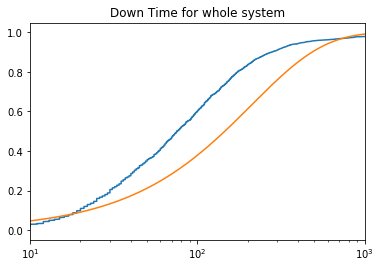

100
0.599273607748
100.048689123
0.378934624697


In [38]:
def find_nearest(x, y, x_value):
    index = (np.abs(np.asarray(x) - x_value)).argmin()
    print(x[index])
    return y[index]

dt_series = np.sort(lanl_node['Down Time'])
_, scale = expon.fit(dt_series, floc=0)
plt.figure()
cdf_samples = np.linspace(0, 1, len(dt_series), endpoint=False)
plt.semilogx(np.sort(dt_series), cdf_samples)
plt.semilogx(expon.ppf(cdf_samples, scale=scale), cdf_samples)

plt.gca().set_xlim(10, 10**3)
plt.title('Down Time for whole system')
plt.show()

print(find_nearest(dt_series, cdf_samples, 100))
print(find_nearest(expon.ppf(cdf_samples, scale=scale), cdf_samples, 100))

    

C:\Users\bsbig.DESKTOP-F0ESDVM\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\bsbig.DESKTOP-F0ESDVM\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


0.00156657448426 0.00156556850088 1.00598337775e-06 0.000642567461713


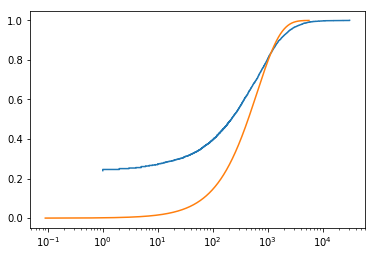

0.000904098929975 0.000904027743764 7.11862113581e-08 7.87433923894e-05


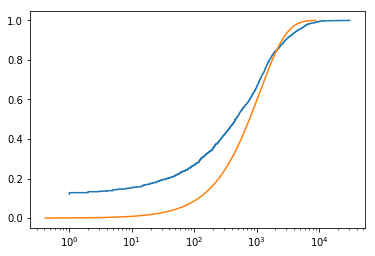

0.00227481645109 0.00227279991193 2.01653915673e-06 0.000887248871381


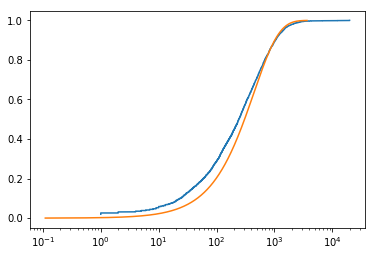

0.00215998223355 0.00215830856056 1.67367299067e-06 0.000775455845957


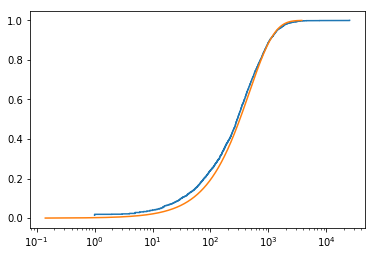

0.00126663886462 0.00126634797734 2.90887285207e-07 0.000229705649958


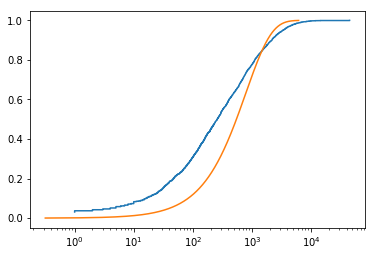

In [86]:
for sys_id in [2, 16, 18, 19, 20]:
    lanl_node = lanl.loc[lanl['System'] == sys_id]
    start_col = lanl_node['Prob Started (mm/dd/yy hh:mm)']
    base_time = start_col.apply(lambda entry: parser.parse(entry).timestamp())
    start_time = base_time.min()
    shift_time = base_time.apply(lambda entry: (entry - start_time) / 60)
    sorted_time = shift_time.sort_values()
    interarrivals = sorted_time.diff()
    _, scale = expon.fit(interarrivals, floc=0)
    mu = interarrivals.mean()
    est_lambda = -np.log(1 - 1 / mu)
    exp_lambda = 1 / scale
    diff = est_lambda - exp_lambda
    print(est_lambda, exp_lambda, diff, diff / exp_lambda)
    
    cdf_samples = np.linspace(0, 1, len(interarrivals), endpoint=False)
    plt.figure()
    plt.semilogx(np.sort(interarrivals), cdf_samples, drawstyle='steps')
    plt.semilogx(expon.ppf(cdf_samples, scale=scale), cdf_samples)
    #plt.semilogx(expon.ppf(cdf_samples, scale=1 / est_lambda), cdf_samples)
    #interarrivals[interarrivals < 1000].hist(bins=100)
    plt.show()

[0.00049437646768013847]


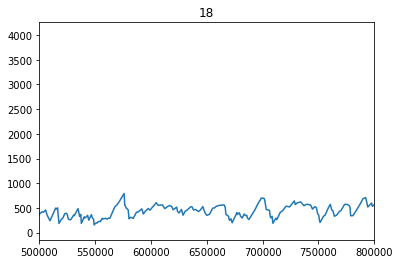

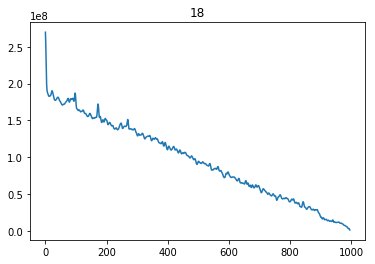

[0.0014123047047400476]


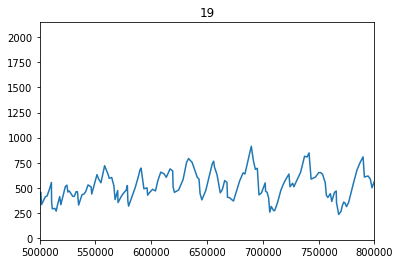

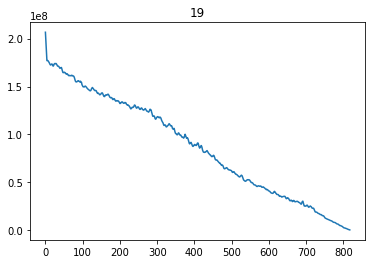

In [127]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

for sys_id in [18, 19]:
    lanl_node = lanl.loc[lanl['System'] == sys_id]
    start_col = lanl_node['Prob Started (mm/dd/yy hh:mm)']
    base_time = start_col.apply(lambda entry: parser.parse(entry).timestamp())
    start_time = base_time.min()
    shift_time = base_time.apply(lambda entry: (entry - start_time) / 60)
    sorted_time = shift_time.sort_values()
    interarrivals = sorted_time.diff()
    #display(sorted_time)
    #display(interarrivals)

    interval_length = 16
    stride = 4
    start_time = 0
    ia_values = np.nan_to_num(interarrivals.values)
    lambdas = []
    new_lambdas = []
    mus = []
    for i in range(len(ia_values[interval_length-1::stride])):
    #for i in range(1):
        interval = ia_values[stride*i : stride*i+interval_length]
        #print(interval)
        mu = interval.mean()
        mus.append(mu)
        if mu > 0:
            test_lambda = -np.log(1 - 1 / (1+mu))
            old_lambda = 1 / mu
        else:
            test_lambda = 0.2
            old_lambda = 0.2
        lambdas.append(old_lambda)
        new_lambdas.append(test_lambda)
        #print(test_lambda * 10**3, old_lambda * 10**3, (old_lambda - test_lambda) * 10**3, start_time)
        #print(interval)
        start_time += interval.sum()

    plt.figure()    
    print(lambdas[0:1])
    #print(np.where(ia_values.cumsum() == 1748619.), ia_values.cumsum()[:-interval_length-1:stride])
    plt.plot(ia_values.cumsum()[interval_length-1::stride], mus)
    #plt.plot(ia_values.cumsum()[interval_length-1::stride], new_lambdas)
    plt.xlim(5e5, 8e5)
    plt.title(sys_id)
    plt.figure()
    plt.plot(autocorr(mus))
    plt.xlim()
    plt.title(sys_id)
    #display(lambdas)
    plt.show()

0        5307122.0
1        5417901.0
2        5417988.0
3        5418250.0
4        5421239.0
5        5422253.0
6        5422377.0
7         929762.0
8         930802.0
9         941067.0
10        944382.0
11        945822.0
12        953343.0
13        961976.0
14        971624.0
15        972508.0
16        972597.0
17        982712.0
18        987661.0
19        991287.0
20        992782.0
21        996902.0
22        997079.0
23       1022606.0
24       1033042.0
25       1049967.0
26       1064740.0
27       1066581.0
28       1073401.0
29       1081981.0
           ...    
23709    2989022.0
23710    3024050.0
23711    3053364.0
23712    3113932.0
23713    3190662.0
23714    3269322.0
23715    3381522.0
23716    3449317.0
23717    3561241.0
23718    3561557.0
23719    3617592.0
23720    3697282.0
23721    3755102.0
23722    3807257.0
23723    3808067.0
23724    3808405.0
23725    3850067.0
23726    3900437.0
23727    3927422.0
23728    3966782.0
23729    3968880.0
23730    396

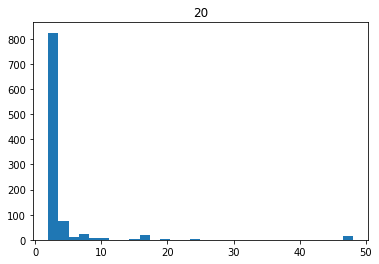

In [48]:
#for sys_id in [2, 16, 18, 19, 20]:
#sys_id = 2
#lanl_node = lanl.loc[lanl['System'] == sys_id]
start_col = lanl['Prob Fixed (mm/dd/yy hh:mm)']
base_time = start_col.apply(lambda entry: parser.parse(entry).timestamp())
start_time = base_time.min()
shift_time = base_time.apply(lambda entry: (entry - start_time) / 60)
print(shift_time)
sorted_time = shift_time.sort_values().values
runs = []
for value, group in itertools.groupby(sorted_time):
    runs.append(len(list(group)))
print(set(runs), len(runs), len(list(filter(lambda x: x > 1, runs))))
runs = list(filter(lambda x: x > 1, runs))
plt.figure()
plt.hist(runs, bins=30)
plt.title(sys_id)
plt.show()
    